In [1]:
import csv
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV

import matplotlib
from matplotlib import pyplot as plt



[nltk_data] Error loading stopwords: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>
[nltk_data] Error loading wordnet: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>


In [2]:
data = pd.read_csv("train.csv") 
data2=pd.DataFrame(data)

In [9]:
data['author']

0        EAP
1        HPL
2        EAP
3        MWS
4        HPL
        ... 
19574    EAP
19575    EAP
19576    EAP
19577    EAP
19578    HPL
Name: author, Length: 19579, dtype: object

<BarContainer object of 1 artists>

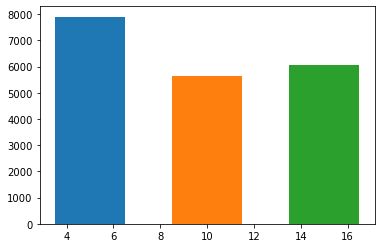

In [42]:
# EAP_len= data[data['author']== 'EAP'].shape[0]
# HPL_len= data[data['author']== 'HPL'].shape[0]
# MWS_len= data[data['author']== 'MWS'].shape[0]
# plt.bar(5,EAP_len, 3, label='EAP')
# plt.bar(10,HPL_len, 3, label='HPL')
# plt.bar(15,MWS_len, 3, label='MWS')

In [3]:
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
def clean(doc):
    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    # POS_LIST = [NOUN, VERB, ADJ, ADV]
    # lemma.lemmatize("rocks")
    # lemma.lemmatize("better", pos="a")
    normalized_1 = " ".join(lemma.lemmatize(word, 'a') for word in punc_free.split()) 
    normalized_2 = " ".join(lemma.lemmatize(word, 'n') for word in normalized_1.split()) #this deleted s from as
    normalized_3 = " ".join(stemmer.stem(word) for word in normalized_2.split()) #this is very effective
    stop_free = " ".join([i for i in normalized_3.lower().split() if i not in stop])
    return stop_free

In [4]:
data['text_clean'] = data['text'].apply(clean) #clean(data['text'][0])  

In [7]:
import pickle
save_word_features = open("pickled/data_features_spooky.pickle","wb")
pickle.dump(data, save_word_features)
save_word_features.close()

In [ ]:
#Tokenize

#TfidfVectorizer() requires data non-tokenized

# tokenizer = RegexpTokenizer(r'\w+')
# data['text'] = data['text'].apply(tokenizer.tokenize)

In [7]:
def cv(data):
    """
    Count vectorizing function.  Returns embedded vector and vectorizer.
    """
    #count_vectorizer = CountVectorizer() # Bag-of-words vectorization
    count_vectorizer = TfidfVectorizer() # Term Frequency-Inverse Document Frequency vectorization
    #count_vectorizer = CountVectorizer(ngram_range =(1, 2)) # n-gram vectorization  
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [17]:
# from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances

# def gen_cos_sim(df):     
#     # Vectorize nose notes
#     n_counts, n_counts_vectorizer = cv(df.tolist())
#     return cosine_similarity(n_counts)

# cos_sim= gen_cos_sim(data['text_clean'])

In [8]:
data.head()

,id,text,author,text_clean
0,id26305,"This process, however, afforded me no means of...",EAP,process however afforded mean ascertaining dim...
1,id17569,It never once occurred to me that the fumbling...,HPL,never occurred fumbling might mere mistake
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand wa gold snuff box capered hill cutti...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,lovely spring looked windsor terrace sixteen f...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else even gold superintendent ...


In [12]:
emb, dictionary = cv(data['text_clean'].tolist())

In [15]:
emb.todense().shape

(19579, 14867)

In [16]:
data.shape

(19579, 4)

In [14]:
from sklearn.model_selection import GridSearchCV

def gen_NaiveBayesClassifier(data, emb, classifier):     
    # freq= pd.Series((' '.join(data['text']).split())).valuecounts().sortvalues(ascending = False)
    # vocab_ = barplotTopWords(freq)
    array = emb.todense()
    emb2= pd.DataFrame(array)
    emb2['output'] = data['author']
    emb2['id'] = data['id']

    features = emb2.columns.tolist()
    output = 'output'
    # removing the output and the id from features
    features.remove(output)
    features.remove('id')

    #list of alpha parameters we are going to try
    alpha_list1 = np.linspace(0.006, 0.1, 2)
    alpha_list1 = np.around(alpha_list1, decimals=4)

    parameter_grid =[{"alpha": alpha_list1}]

    classifier1= classifier() #MultinomialNB, BernoulliNB
    # GridSearchCV allows to tune parameters of a model through k-fold cross validation using parameter grid
    # gridsearch object using 4 fold cross validation and neg_log_loss as scoring paramter
    
    gridsearch1 = GridSearchCV(classifier1,parameter_grid, scoring = 'neg_log_loss', cv = 2)
    
    my_model= gridsearch1.fit(emb2[features], emb2[output])
    return my_model

gridsearch1 = gen_NaiveBayesClassifier(data, emb, MultinomialNB)

In [15]:
gridsearch1

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': array([0.006, 0.1  ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [52]:
instance= emb.todense() [0:500]
instance2= pd.DataFrame(instance)
instance2

,0,1,2,3,4,5,6,7,8,9,...,22366,22367,22368,22369,22370,22371,22372,22373,22374,22375
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.261653,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def predict_NaiveBayesClassifier(instance, gridsearch1):
    
    results1 = pd.DataFrame()
    # collect alpha list
    results1['alpha'] = gridsearch1.cv_results_['param_alpha'].data
    # collect test scores
    results1['neglogloss'] = gridsearch1.cv_results_['mean_test_score'].data

#     matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
#     plt.plot(results1['alpha'], -results1['neglogloss'])

    "Best parameter: ", gridsearch1.best_params_
    "Best score: ",gridsearch1.best_score_ 
    gridsearch1.best_estimator_  
#     my_model.best_estimator_.feature_importances #MultinomialNB' object has no attribute 'feature_importances'

    prediction= gridsearch1.predict(instance)
    

    return prediction, gridsearch1.best_params_, gridsearch1.best_score_ , gridsearch1.best_estimator_  


prediction, best_params, best_score, best_estimator= predict_NaiveBayesClassifier(instance2, gridsearch1)
# prediction,best_params, best_score, best_estimator

The Code for Prediction stops here, 
Now we try some performance metrics from Geron Book

In [ ]:
n_correct= sum(prediction == data['author'][0:500])
me= n_correct/len(prediction)
me

In [79]:
#BINARY CLASSIFIER
X_train=emb.todense()
y_train_EAP= data['author']== 'EAP'
classifier1= MultinomialNB()

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_EAP):
    clone_classifier= clone(classifier1)
    X_tn_folds = X_train[train_index]
    y_tn_folds = y_train_EAP[train_index]
    X_tt_fold = X_train[test_index]
    y_tt_fold = y_train_EAP[test_index]
    clone_classifier.fit(X_tn_folds, y_tn_folds)
    
    y_pred= clone_classifier.predict(X_tt_fold)
    n_correct= sum(y_pred == y_tt_fold)
    print(n_correct/len(prediction))

y_pred.shape #this prediction is on 1/3 of the whole dataset

10.586
10.6
10.646


array([False, False, False, ...,  True, False, False])

In [88]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(classifier1, X_train, y_train_EAP, cv=3) #this is on whole dataset

array([ True, False,  True, ...,  True, False, False])

In [89]:
y_train_pred

array([ True, False,  True, ...,  True, False, False])

In [85]:
# with unbalanced datasets (only a few from class 1) don't use accuracy 
# use confusion matrix: number of times instances of class A are classified as B

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_EAP, y_train_pred) 
#y_train_EAP is a boolean vector with True if the instance is authored by EAP , and False if it is not
#data['author']== 'EAP' %This is the ground truth

#y_train_pred is a boolean vector with True if the instance is classified as by EAP , and False if it is not
# y_train_pred = cross_val_predict(classifier1, X_train, y_train_EAP, cv=3) #this is on whole dataset


array([[11357,   322],
       [ 3341,  4559]])

In [90]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_EAP, y_train_pred)

0.9340299119032985

In [91]:
recall_score(y_train_EAP, y_train_pred)

0.5770886075949367

In [92]:
from sklearn.metrics import f1_score
f1_score(y_train_EAP, y_train_pred)

0.7134027071434161

In [132]:
#change decision function
# y_score= classifier1.decision_function(emb.todense()[0])
# from sklearn.linear_model import SGDClassifier

classifier2= SGDClassifier()
classifier2.fit(X_train, y_train_EAP)
classifier2.predict(emb.todense()[0])

array([ True])

In [117]:
y_decisionscore=cross_val_predict(classifier2, X_train, y_train_EAP, cv=3,  method="decision_function") #this is on whole dataset 

In [107]:
#PRECISION RECALL CURVE, cannot make it because I cannot get the thresholds!!
from sklearn.metrics import precision_recall_curve
precision, recall, thresh = precision_recall_curve(y_train_EAP, y_decisionscore)

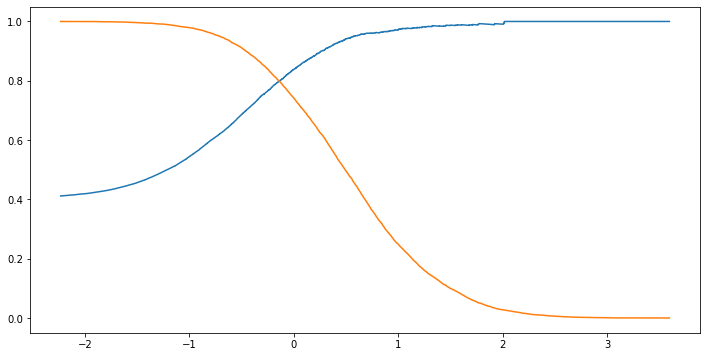

In [108]:
plt.plot(thresh, precision[:-1])
plt.plot(thresh, recall[:-1])

In [109]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds= roc_curve( y_train_EAP, y_decisionscore)

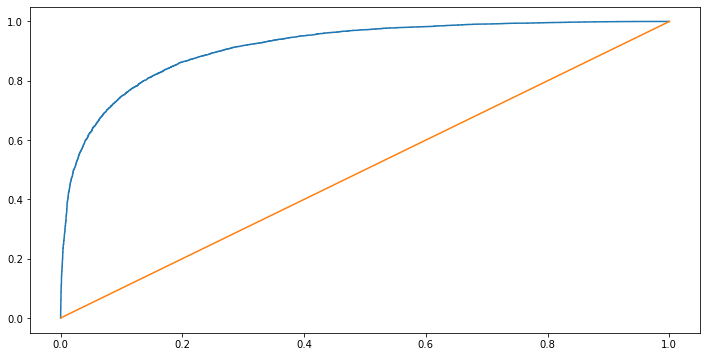

In [110]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0,1])

In [116]:
#MultinomialNB does not have decision_function method, needs predict_proba
y_proba=cross_val_predict(classifier1, X_train, y_train_EAP, cv=3,  method="predict_proba") #this is on whole dataset
y_proba.shape #the first columns is the negative class probability, and second columns is the positive class probability

In [118]:
y_proba

array([[0.28052997, 0.71947003],
       [0.51666501, 0.48333499],
       [0.42382416, 0.57617584],
       ...,
       [0.33220781, 0.66779219],
       [0.69577992, 0.30422008],
       [0.66059481, 0.33940519]])

In [121]:
y_decisionscore 

array([ 1.41846552,  0.56206715,  0.42165101, ...,  0.57752415,
       -0.87792875, -0.51548372])

In [123]:
fpr2, tpr2, thresholds2= roc_curve( y_train_EAP, y_proba[:,1])

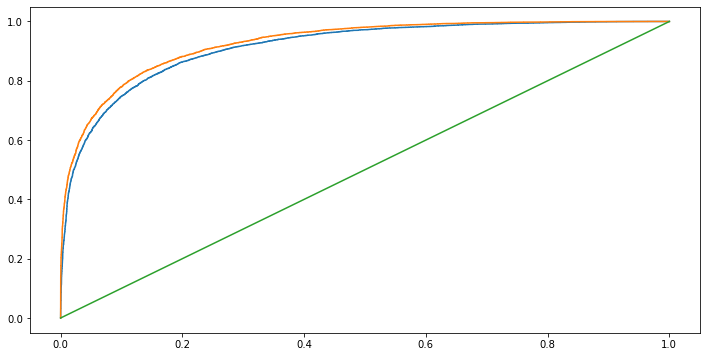

In [125]:
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.plot([0, 1], [0,1])

In [126]:
array = emb.todense()
emb2= pd.DataFrame(array)
emb2['output'] = data['author']
emb2['id'] = data['id']

features = emb2.columns.tolist()
output = 'output'
features.remove(output)
features.remove('id')

classifi= MultinomialNB() #MultinomialNB, BernoulliNB

multiclass= classifi.fit(emb2[features], emb2[output])

In [130]:
multiclass.predict_proba(emb.todense()[0]) #the proobability that line 0 is 1st 2nd or 3rd class

array([[0.88618113, 0.05674752, 0.05707135]])

In [131]:
multiclass.classes_

array(['EAP', 'HPL', 'MWS'], dtype='<U3')